In [4]:
# ignore the warning
import warnings
warnings.filterwarnings("ignore")

In [94]:
# import the required library
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes()
from IPython.display import display

from util import lenCategory
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import unicodedata
import re

from collections import Counter
from wordcloud import WordCloud, STOPWORDS

In [5]:
pd.set_option('display.max_colwidth', None) # It will enable the entire row visible with truncation of the text. (We can see full text.)

In [6]:
# custom function to load the data
def loadData(path):
    data = pd.read_csv(path)
    data = data.drop_duplicates("review")
    data["len"] = data.apply(lambda x : len(str(x["review"]).split()) , axis = 1)
    data["lencat"] = data.apply(lambda x : lenCategory(x["len"]) , axis = 1)
    return data

In [14]:
# load the train, holdout and test( no labels) set
traindata = loadData('train_data.csv')
holdoutdata = loadData('holdout_data.csv')
testdata = loadData('test_data.csv')

In [15]:
# conbine the train and holdout as a single train data
train = pd.concat([traindata, holdoutdata], ignore_index=True)

## Check the shape of train and test data

In [16]:
# shape of train data
display(train.shape)

(882380, 6)

In [18]:
# shape of test data
display(testdata.shape)

(99995, 4)

## Take a look at the head

In [24]:
display(train.head()) # for train

,review,summary,score,sentiment,len,lencat
0,This was a difficult read but I stuck it out till the end. Guess what there is freak in cliffhanger. So the question is- Is it worth the dollars to figure out what happens. I am not so sure.,Are you kidding me?,2.0,0,39,26-50
1,"Great read! I loved everything about this book. If you are not into dominant males who will use whatever it takes to get his woman then this book is not for you. While it is heavy into BDSM, Love is present. Great love is always complicated, but Ms. Mynx can be counted on to create a wonderful story full of romance, suspense, great sex, a hint of mystery and did I mention the hot love scenes? Lol! I didn't want this book to end. Keep them coming. I have a special weakness for men foreign to the good old USA. I would give this book 10 stars if I could. Best non series book I've read by this author.",Never disappointed!,5.0,2,119,101-250
2,"I really like this story,Home for Christmas, except for the fact that the male character can't keep his mind on positive things; he wants to kiss on the second day that he knows his best friend and partner's younger sister. Unreal! I like the cowboy setting but this fellow reinforces her brother's opinion of cowboys. This story gives the reader the impression that all cowboys are like this one.","Good Plot, Excellent Setting",3.0,1,69,51-100
3,I like the book from the beginning to the end It is about Logan Harper helping a family friend find his grandbaby and bringing her home alive. Action all the way through. A good read!,A good read!,3.0,1,35,26-50
4,"After reading the first book in this stand alone series Cain's Salvation I was literally chomping at the bit to get my hands on the next instalment from the town of Paradise. The McKinnon sisters are my ultimate set of heroines, each girl has a past and issues and are so full of humour and love that from reading about them you feel like a part of the family.Hard as Stone is Harmony's turn to find love. Enter our ruggedly handsome older DEA agent Jacob Stone who has a bit of a hidden agenda when he first encounters our protagonist Harmony but after sending a bit of time with her and her gorgeous piece of Heaven (wink wink) Jacob discovers that there's maybe more to life than revenge and solitude.I won't go into too much detail about the storyline because it's one that once you start you'll be completely sucked in and maybe, possibly forget you have a house to clean, children to raise and a husband to cater to. But it is sooo worth it. So much happens I probably couldn't tell you all of it anyway.The writing is fabulous, it flows so easily as scene after scene packs a punch filled with everything- comedy, tragedy, romance and of course those very hot and naughty scenes with our main couple. I'm beyond excited for this series to continue. The characters are brilliant and pop right off the page and into your heart. The writing is engaging and the dialogue is superb. The two wonderful writers that make up Sarah O'Rourke are golden, they manage to convey each individual person's unique personality through their words. Total five star from me.",Fantastic book,5.0,2,280,251-500


In [20]:
display(testdata.head()) # for test

,review,summary,len,lencat
0,"This book has so many good things going on that I cannot divulge them all without spoiler alerts. Samantha, a nerdy consultant, has been talked into taking on a client of her best friend Natalie who happens to be an escort. The date is with a wealthy investor named Joel who has other motives in mind than to spend a few hours with a beautiful woman for pay.Where most erotic/romance pieces build into deeper sexual connections as the plot progresses, this books builds in reverse. We start out with hot, steamy scenes of intense erotic situations, but as the story progresses, the relationship between the female and male protagonist builds into a deeper romantic meaning making the erotic moments much sweeter.As my title for this review implies, if you are a lover of the movie Pretty Woman and you can handle dominant sex, then you should be all over this short read like I was. I finished in a few hours and I was completely sated from the story. I have read some of this author's paranormal/fantasy pieces, but A Date To Remember is something that I will always remember.",A `Pretty Woman' Tale...,190,101-250
1,"Loved this set. Only minor complaint is it should be encouraged to be read first since it introduces the Drs. to the whole family of Grace Valley and Virgin River. Not a biggie though - Robyn Carr is a fantastic writer and I love, laugh and cry through all her books.",The Grace Valley Trilogy,51,51-100
2,"The love that was hard and easy to fine. Sometime if you stop looking it will be right in your face. She didn't know what love was until she met Jack,he showed her something she father and mother never did. He showed her what she was missing.",The love of my life,47,26-50
3,Loved to read this book. Haven't tried these just yet! Would recommend to others improving their sexual and relationship side of life.,Great Book!,22,11-25
4,"This book was full of a little bit of everything ,romance suspense humor sex(done nicely).The part when she was play acting like Clint Eastwood was so funny!",Wow!,27,26-50


### Insights : 
#### We see the train data has review and summary columns which are text data and will likely be used as input features. 
#### There is a score column which is the score given by users.
#### The sentiment column is a derived column from score. score 1 and 2 means negative (labelled as 0), score 3 is neutral (labelled as 1) and scrore 4 and 5 indicates positive labelled as 2
#### There are two additional derived columns len and lencat. len indicates how many words are present in a particular review wheras lencat denotes a predifined category based on the length.
#### For test data we dont have sentiment and score columns as this is what we will predict

## Check for NULL Values if any

In [21]:
# for train
train.isna().sum()

review       2
summary      1
score        0
sentiment    0
len          0
lencat       0
dtype: int64

In [23]:
# for test
testdata.isna().sum()

review     1
summary    0
len        0
lencat     0
dtype: int64

### We can see we have very tiny amount of nulls in text data in single digits and we will drop it for the analysis

In [25]:
# drop the nulls 

train = train.dropna()
testdata = testdata.dropna()

### Check the distribution of sentiment in train data

In [26]:
# check the distribution
display(train.sentiment.value_counts())

2    744684
1     86326
0     51367
Name: sentiment, dtype: int64

In [27]:
# check the distribution in percentage
display(train.sentiment.value_counts(normalize=True))

2    0.843952
1    0.097833
0    0.058214
Name: sentiment, dtype: float64

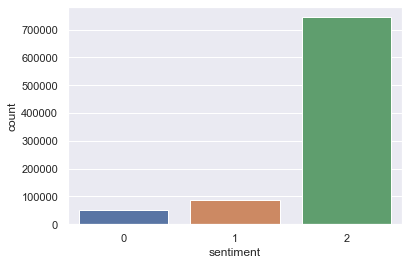

In [30]:
sns.set_theme()
sns.countplot(train.sentiment); # 

### Insights : 
#### We can see that the data is highly inbalaced. Positive is about 84% of the entire data , neutral around 10 percent and negative at  6%.
#### What we can say in advance tha it will be difficult to model this data with good precision and recall for negative and neutral.

## Check the distribution of review accoriding to length

In [31]:
# check the distribution
display(train.lencat.value_counts())

26-50        246990
51-100       221821
101-250      193673
11-25        123331
251-500       74902
501-1000      18246
1001-2500      1290
6-10           1120
4-5             431
2               245
3               217
1                96
2501-5000        15
Name: lencat, dtype: int64

In [32]:
# check the distribution in percentage
display(train.lencat.value_counts(normalize=True))

26-50        0.279914
51-100       0.251390
101-250      0.219490
11-25        0.139771
251-500      0.084887
501-1000     0.020678
1001-2500    0.001462
6-10         0.001269
4-5          0.000488
2            0.000278
3            0.000246
1            0.000109
2501-5000    0.000017
Name: lencat, dtype: float64

In [39]:
# check the distribution in percentage in negative
display(train[train.sentiment == 0].lencat.value_counts(normalize=True))

# check the distribution in percentage in neutral
display(train[train.sentiment == 1].lencat.value_counts(normalize=True))

# check the distribution in percentage in positive
display(train[train.sentiment == 2].lencat.value_counts(normalize=True))

26-50        0.285495
51-100       0.252867
101-250      0.215839
11-25        0.151537
251-500      0.070045
501-1000     0.018611
6-10         0.001849
1001-2500    0.001811
4-5          0.000798
3            0.000448
2            0.000350
1            0.000253
2501-5000    0.000097
Name: lencat, dtype: float64

26-50        0.268471
101-250      0.227996
51-100       0.226525
11-25        0.145970
251-500      0.102113
501-1000     0.024593
1001-2500    0.001610
6-10         0.001402
4-5          0.000533
2            0.000348
3            0.000290
1            0.000139
2501-5000    0.000012
Name: lencat, dtype: float64

26-50        0.280856
51-100       0.254171
101-250      0.218756
11-25        0.138241
251-500      0.083913
501-1000     0.020367
1001-2500    0.001421
6-10         0.001214
4-5          0.000462
2            0.000265
3            0.000227
1            0.000095
2501-5000    0.000012
Name: lencat, dtype: float64

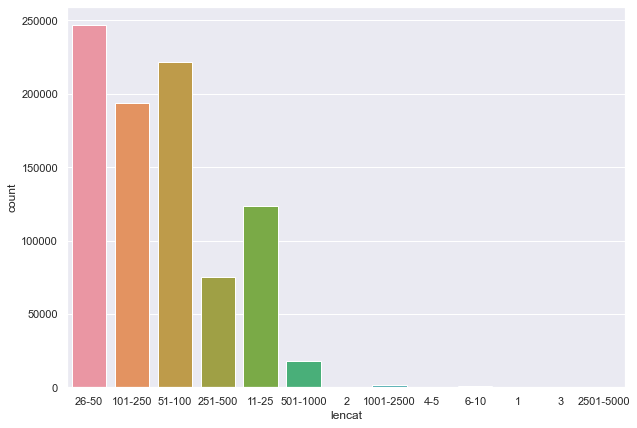

In [34]:
plt.figure(figsize=(10,7))
sns.set_theme()
sns.countplot(train.lencat); # 

### Insights:
#### We can see reviews with word count 25-50 is most frequest about 28 %.
#### Around 90% of reviews are less that 250 word count lengtn.
#### there are some review which are very large in length and has like between 2500~5000 tweets.

### We can also obseve that the distribution is almost similar in negative, neutral and positive tweets. Hence the length of review may not act a feature (Also I believe its like adding external bias)


### We may likely have to build two seperate models to deal with very large ( > 250 words count ) and other ( < 250 ).

## Visualize top words occuring in each sentiment category

### First step is to pre-process the text like removing stop words, removing special characters etc

In [64]:
stopwords = stopwords.words('english') # import default stopwords list
def remove_stopwords(text):
    '''
    Function to remove stopwords
    params"
    text : sting
    '''
    tokens = word_tokenize(text)
    return " ".join([token for token in tokens if token not in stopwords])

def remove_accented_chars(text):
    '''
    Function to remove accented characters, using python unicodedate in the backgroud
    params:
    text : string
    '''
    
    # normalise usng NFKF , encode to ascii and decode to utf-8
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_special_characters(text, remove_digits=False):
    '''
    function to remove special characters, punctuations and digits
    params:
    text : string
    remove_digits: whether to remove digits or not, default is false
    '''
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, ' ', text)
    return text

In [50]:
def preprocess(text):
    text = text.lower() # lower case the text
    text = text.translate(text.maketrans("\n\t\r", "   "))# remove extra newlines (often might be present in really noisy text)
    text = remove_accented_chars(text) # remove accented characters
    text = remove_special_characters(text, remove_digits=True) # remove special chars along with digits 
    text = remove_stopwords(text) # remove stopwords
    text = text.strip() # remove trailing whitespaces
    return text

In [52]:
train_text = list(train.review)
clean_text = []
c = 0
for i in train_text:
    c += 1
    if c % 1000 == 0:
        print(c)
    clean_text.append(preprocess(i))
train["clean_review"] = clean_text

In [78]:
train.head(2)

,review,summary,score,sentiment,len,lencat,clean_review
0,This was a difficult read but I stuck it out till the end. Guess what there is freak in cliffhanger. So the question is- Is it worth the dollars to figure out what happens. I am not so sure.,Are you kidding me?,2.0,0,39,26-50,difficult read stuck till end guess freak cliffhanger question worth dollars figure happens sure
1,"Great read! I loved everything about this book. If you are not into dominant males who will use whatever it takes to get his woman then this book is not for you. While it is heavy into BDSM, Love is present. Great love is always complicated, but Ms. Mynx can be counted on to create a wonderful story full of romance, suspense, great sex, a hint of mystery and did I mention the hot love scenes? Lol! I didn't want this book to end. Keep them coming. I have a special weakness for men foreign to the good old USA. I would give this book 10 stars if I could. Best non series book I've read by this author.",Never disappointed!,5.0,2,119,101-250,great read loved everything book dominant males use whatever takes get woman book heavy bdsm love present great love always complicated ms mynx counted create wonderful story full romance suspense great sex hint mystery mention hot love scenes lol want book end keep coming special weakness men foreign good old usa would give book stars could best non series book read author


[('book', 947391),
 ('story', 552554),
 ('read', 529254),
 ('love', 378505),
 ('one', 375347),
 ('like', 250566),
 ('series', 248865),
 ('really', 242170),
 ('great', 240983),
 ('characters', 238505),
 ('good', 237989),
 ('well', 209217),
 ('would', 198260),
 ('books', 189827),
 ('get', 189586),
 ('author', 188121),
 ('loved', 176888),
 ('reading', 173261),
 ('first', 166856),
 ('time', 157675)]

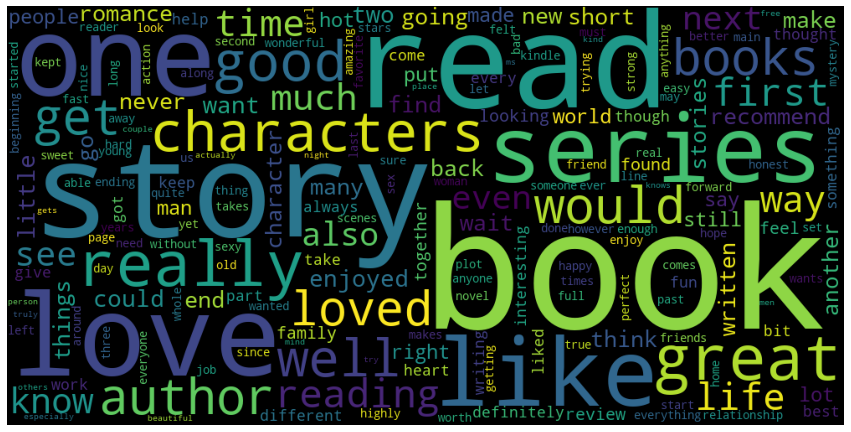

In [101]:
positive_words = []
for i in train[train.sentiment == 2].clean_review:
    positive_words += i.split()
positiveCounter = Counter(positive_words)
display(positiveCounter.most_common(20))
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(positiveCounter)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

[('book', 66564),
 ('story', 38241),
 ('like', 27175),
 ('read', 26620),
 ('one', 24742),
 ('would', 20163),
 ('really', 18366),
 ('author', 17847),
 ('get', 15547),
 ('characters', 15175),
 ('good', 15035),
 ('time', 13652),
 ('even', 13436),
 ('much', 12752),
 ('first', 11899),
 ('books', 11864),
 ('could', 11647),
 ('reading', 11338),
 ('love', 10048),
 ('way', 9522)]

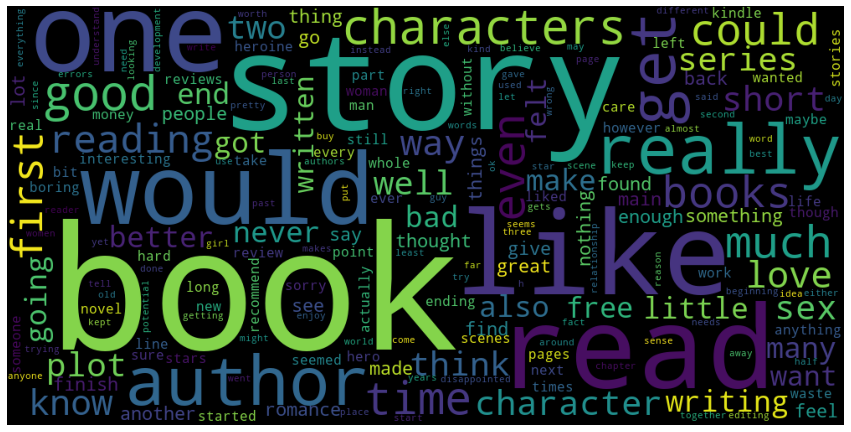

In [100]:
negative_words = []
for i in train[train.sentiment == 0].clean_review:
    negative_words += i.split()
negativeCounter = Counter(negative_words)
display(negativeCounter.most_common(20))
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(negativeCounter)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

[('book', 106339),
 ('story', 85463),
 ('read', 59111),
 ('like', 46194),
 ('one', 43042),
 ('would', 38373),
 ('good', 38245),
 ('really', 35849),
 ('characters', 31455),
 ('love', 25389),
 ('author', 25151),
 ('get', 25104),
 ('much', 24042),
 ('little', 22184),
 ('first', 21799),
 ('series', 21758),
 ('time', 20995),
 ('well', 20254),
 ('books', 19556),
 ('could', 19326)]

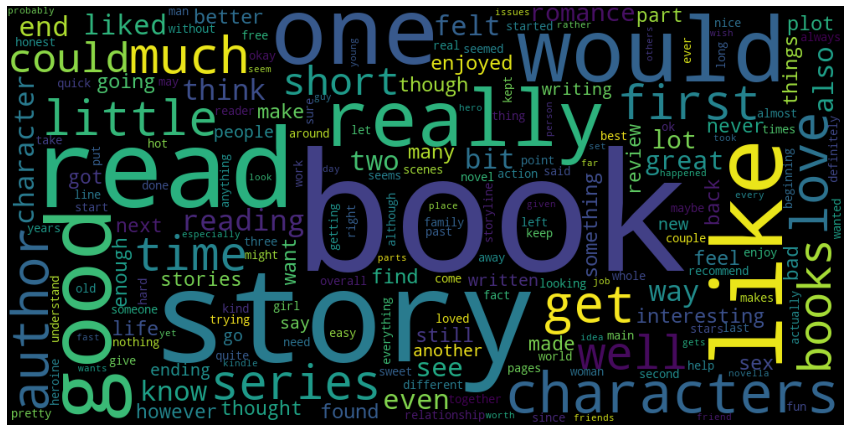

In [102]:
neutral_words = []
for i in train[train.sentiment == 1].clean_review:
    neutral_words += i.split()
neutralCounter = Counter(neutral_words)
display(neutralCounter.most_common(20))
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(neutralCounter)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()